In [8]:
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import FormatStrFormatter
from pydotplus import *
from IPython.display import Image
import os

# Consulting Project : Robust Reinforcement Learning

# Cartpole

In [105]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/Cartpole_ver1/EnvTest_Cart/cart_t200_longerPole.csv")


In [106]:
data = data.drop(data.columns[[0]], axis=1)
data['Q_Diff'] = data['Q_Value_0'] - data['Q_Value_1']

# Cartpole Policy Visualisation

In [107]:
df = pd.pivot_table(data=data,
                    index='Pole_Angular_Velocity',
                    values= 'Q_Diff',
                    columns='Pole_Angle')

xMIN = -0.2
xMAX = 0.2
yMIN = -4
yMAX = 4
#Delete all colums above and below certain values
for column in df.columns.values:
    if(float(column) <= xMIN or float(column) >= xMAX):
        df.drop(column, 1, inplace=True)

#Delete all rows above and below certain values
for row in df.index.values:
    if(float(row) <= yMIN or float(row) >= yMAX):
        df.drop(row, 0, inplace=True)
       

Text(0.5, 1.0, 't=200, longer Pole')

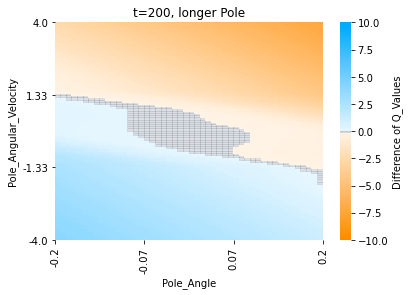

In [108]:
cmap = sns.diverging_palette(45, 255, sep = 1, as_cmap=True, s = 190, l =70)
colorspace = cmap(np.linspace(0,1, 201))
colorspace[100] = [0.55, 0.59, 0.64, 0.3]
cmap = ListedColormap(colorspace)

xticks = np.linspace(xMIN, xMAX, 4)
yticks = np.linspace(yMIN, yMAX, 4)
spacing = np.linspace(0,1,4)

hmap = sns.heatmap(df, center = 0, cmap = cmap, cbar_kws={'label': 'Difference of Q_Values'}, xticklabels=xticks, yticklabels=yticks, vmax = 10, vmin = -10)

hmap.invert_yaxis()

xlabels = [i.get_text() for i in hmap.get_xticklabels()]
hmap.set_xticklabels([str(round(float(label),2)) for label in xlabels])

ylabels = [i.get_text() for i in hmap.get_yticklabels()]
hmap.set_yticklabels([str(round(float(label),2)) for label in ylabels])

hmap.set_xticks(spacing*hmap.get_xlim()[1])
hmap.set_yticks(spacing*hmap.get_ylim()[1])

#hmap.set_xticks([0,49])

hmap.set_title('t=200, longer Pole')

In [109]:
fig = hmap.get_figure()   # only for Version 2020. 
fig.tight_layout()
fig.savefig('cart_t200_longerPole.png')             

# Visualisation of Plays using Scatter Plot

In [2]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/playOutputCartPole-v0normal_0_500_0.2_0_0.022_1.csv")

In [3]:
data = data.drop(data.columns[[0]], axis=1)
data['Q_Diff'] = data['Q_Value_0'] - data['Q_Value_1']  # compute the difference between two q-values
data.loc[data['Action'] == 0, 'Action'] = 'left'
data.loc[data['Action'] == 1, 'Action'] = 'right'

Text(0.5, 1.0, 't=500, shorter Pole')

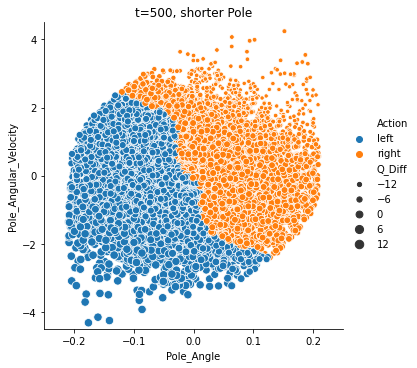

In [4]:
# If you want to mark the decision boundary with white colour
#cmap = sns.diverging_palette(20, 220, sep = 1, as_cmap=True)
#colorspace = cmap(np.linspace(0,1, 301))
#st_hue = sns.relplot(x="Pole_Angle", y="Pole_Angular_Velocity", hue_norm = (-0.1,0.1), hue = "Q_Diff", data = dat, palette=cmap)
#plt.title('Timestep: 200, Environment: Standard')

scatter = sns.relplot(x="Pole_Angle", y="Pole_Angular_Velocity", hue='Action', hue_order = ['left', 'right'], size = 'Q_Diff',data = data)
scatter.set(xlim = (-0.25, 0.25), ylim = (-4.5, 4.5), xticks=[-0.2, -0.1, 0, 0.1, 0.2], yticks=[-4,  -2, 0, 2, 4])
plt.title('t=500, shorter Pole')

In [6]:
scatter.savefig('cartplay_t500_shorter Pole.png')   

# Compute the perturbation radius ɛ for CartPole

In [816]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/playOutputCartPole-v0normal_0_500_0.2_0_0.03.csv")

In [817]:
data = data.drop(data.columns[[0]], axis=1)
data['Q_Diff'] = data['Q_Value_0'] - data['Q_Value_1']

In [818]:
data = data[abs(data['Q_Diff']) > 0.05]  # 0.05 = (20 / 201)/2 

In [819]:
data = data.sample(n = 10000, replace = False)

In [820]:
data_action0 = data[data['Action'] == 0]
data_action1 = data[data['Action'] == 1]

In [821]:
max_angle = 0.418
min_angle = -0.418
max_velocity = 4
min_velocity = -4

In [822]:
data['Pole_Angle'] =  (data['Pole_Angle'] - min_angle )/(max_angle - min_angle)
data['Pole_Angular_Velocity'] =  (data['Pole_Angular_Velocity'] - min_velocity)/(max_velocity - min_velocity)

In [824]:
# compute 
histo = []
mind = np.Inf
for i, row0 in data_action0.iterrows():
    local_mind = np.Inf
    for j, row1 in data_action1.iterrows():
        a = np.array([row0['Pole_Angle'], row0['Pole_Angular_Velocity']])
        b = np.array([row1['Pole_Angle'], row1['Pole_Angular_Velocity']])
        if abs(a[0] - a[1]) > local_mind or abs(b[0] - b[1]) > local_mind:
            continue
        current_dist = np.linalg.norm(a-b)
        if current_dist < local_mind:
            local_mind = current_dist      
    if local_mind < mind:
        mind = local_mind
    histo.append(local_mind) 

# Mountain Car

In [833]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/MountainCar-v0mountain_car_0_200_0.002_5_0.0014.csv")


In [834]:
data = data.drop(data.columns[[0]], axis=1)

In [835]:
data['Q_Diff'] = data['Q_Value_0'] - data['Q_Value_1']

In [710]:
# Compute the difference between best Q value and second best Q value (for 3 actions)
#def findQ(q0, q1, q2):
#    arr = [q0,q1,q2]
#    arr.sort(reverse = True)
#    return arr[0] - arr[1]

#data['Q_Diff'] = data.apply(lambda row : findQ(row['Q_Value_0'], row['Q_Value_1'],row['Q_Value_2']), axis = 1)   

## Mountain Car Policy Visualization

## Random Sampling 

In [836]:
df = pd.pivot_table(data=data,
                    index='Car_Velocity',
                    values= 'Q_Diff',
                    columns='Car_Position')

xMIN = -1.2
xMAX = 0.6
yMIN = -0.06
yMAX = 0.06
#Delete all colums above and below certain values
for column in df.columns.values:
    if(float(column) <= xMIN or float(column) >= xMAX):
        df.drop(column, 1, inplace=True)

#Delete all rows above and below certain values
for row in df.index.values:
    if(float(row) <= yMIN or float(row) >= yMAX):
        df.drop(row, 0, inplace=True)
       

Text(0.5, 1.0, 't=200, g=0.002, beta=5, esp=0.0014')

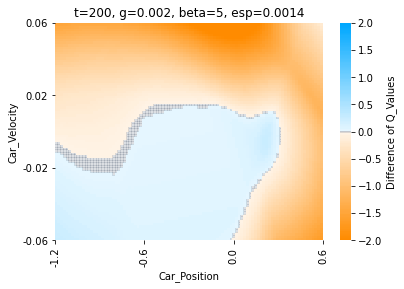

In [837]:
# Heat Map
cmap = sns.diverging_palette(45, 255, sep = 1, as_cmap=True, s = 190, l =70)
colorspace = cmap(np.linspace(0,1,201))
colorspace[100] = [0.55, 0.59, 0.64, 0.3]
cmap = ListedColormap(colorspace)

xticks = np.linspace(xMIN, xMAX, 4)
yticks = np.linspace(yMIN, yMAX, 4)
spacing = np.linspace(0,1,4)

hmap = sns.heatmap(df, center = 0, cmap = cmap, cbar_kws={'label': 'Difference of Q_Values'}, xticklabels=xticks, yticklabels=yticks, vmax = 2, vmin = -2)
hmap.invert_yaxis()

xlabels = [i.get_text() for i in hmap.get_xticklabels()]
hmap.set_xticklabels([str(round(float(label),2)) for label in xlabels])

ylabels = [i.get_text() for i in hmap.get_yticklabels()]
hmap.set_yticklabels([str(round(float(label),2)) for label in ylabels])

hmap.set_xticks(spacing*hmap.get_xlim()[1])
hmap.set_yticks(spacing*hmap.get_ylim()[1])

#Beta: 3, Eps: 0.003
hmap.set_title('t=200, g=0.002, beta=5, esp=0.0014')

In [838]:
fig = hmap.get_figure()   # only for Version 2020. 
fig.tight_layout()
fig.savefig('MC_t200_g0002_B5E00014.png')

## For Real Values from play

In [828]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/playOutputMountainCar-v0mountain_car_0_200_0.002_5_0.0014.csv")

In [829]:
data = data.drop(data.columns[[0]], axis=1)
data['Q_Diff'] = abs(data['Q_Value_0'] - data['Q_Value_1'])

In [830]:
# change 0 to left, 1 to right
data.loc[data['Action'] == 0, 'Action'] = 'left'
data.loc[data['Action'] == 1, 'Action'] = 'right'

Text(0.5, 1.0, 'g=0.002, Beta=5, Epsilon=0.0014')

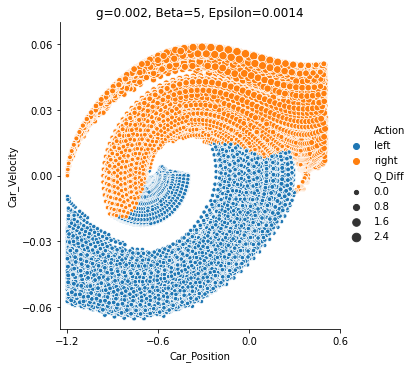

In [831]:
# Scatter plot for real value from play
scatter = sns.relplot(x="Car_Position", y="Car_Velocity", hue = 'Action', hue_order = ['left', 'right'], size = 'Q_Diff', data = data)
scatter.set(xlim = (-1.25, 0.6), ylim = (-0.07, 0.07), xticks=[-1.2, -0.6, 0, 0.6], yticks=[-0.06,  -0.03, 0, 0.03, 0.06])
plt.title('g=0.002, Beta=5, Epsilon=0.0014')

In [832]:
#fig = scatter.get_figure()   # only for Version 2020. 
fig.tight_layout()
scatter.savefig('MC_g0002_B5E00014play.png')   

# Compute the perturbation radius parameter ɛ

In [802]:
data = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/playOutputMountainCar-v0mountain_car_0_200_0.002_0_0_1.csv")

In [803]:
data = data.drop(data.columns[[0]], axis=1)
data['Q_Diff'] = data['Q_Value_0'] - data['Q_Value_1']

In [804]:
data = data[abs(data['Q_Diff']) > 0.009]  # 0.009 = (4 / 201)/2 

In [805]:
data = data.sample(n = 10000, replace = False)

In [807]:
data_action0 = data[data['Action'] == 0]
data_action1 = data[data['Action'] == 1]

In [808]:
max_pos = 0.6
min_pos = -1.2
max_velocity = 0.07
min_velocity = -0.07

In [809]:
data['Car_Position'] =  (data['Car_Position'] - min_pos )/(max_pos - min_pos)
data['Car_Velocity'] =  (data['Car_Velocity'] - min_velocity)/(max_velocity - min_velocity)

In [811]:
histoo = []
minde = np.Inf
for i, row0 in data_action0.iterrows():
    local_mind = np.Inf
    for j, row1 in data_action1.iterrows():
        current_dist = np.linalg.norm(np.array([row0['Car_Position'], row0['Car_Velocity']]) - np.array([row1['Car_Position'], row1['Car_Velocity']]))
        if current_dist < local_mind:
            local_mind = current_dist      
    if local_mind < minde:
        minde = local_mind
    histoo.append(local_mind) 

# Visualisation of Reward Development

In [1127]:
logdata = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputMountainCar-v0mountain_car_0_200_0.002_3_0.0014_play_1.csv")

In [929]:
logdata = logdata.drop(logdata.columns[[0]], axis=1)
logdata

,Total T,Episode,Position,Velocity,Reward
0,200,1,-0.663635,0.028978,-200.0
1,400,2,0.095822,0.021822,-200.0
2,596,3,0.501685,0.010395,-196.0
3,796,4,-0.450273,-0.030123,-200.0
4,996,5,-0.493854,-0.052354,-200.0
...,...,...,...,...,...
1015,199083,1016,-0.498359,-0.018657,-200.0
1016,199283,1017,-0.408200,0.000085,-200.0
1017,199483,1018,-0.991618,0.007610,-200.0
1018,199683,1019,-1.158523,-0.035628,-200.0


# Epsilon, Beta Effect

In [119]:
# read data from play (evaluation)


playdata0 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0normal_0_500_0.2_0_0.022_play_1.csv")
playdata0 = playdata0.drop(playdata0.columns[[0]], axis=1)

playdata1 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0normal_0_500_0.2_10_0.015_play.csv")
playdata1 = playdata1.drop(playdata1.columns[[0]], axis=1)

playdata2 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0noise_0_500_0.2_0_0_play.csv")
playdata2 = playdata2.drop(playdata2.columns[[0]], axis=1)

playdata3 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0noise_0_500_0.2_10_0.015_play.csv")
playdata3 = playdata3.drop(playdata3.columns[[0]], axis=1)

playdata4 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0adversary_0_500_0.2_0_0_play.csv")
playdata4 = playdata4.drop(playdata4.columns[[0]], axis=1)

playdata5 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0adversary_0_500_0.2_10_0.015_play.csv")
playdata5 = playdata5.drop(playdata5.columns[[0]], axis=1)

playdata6 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0DR_0_500_0.2_0_0_play.csv")
playdata6 = playdata6.drop(playdata6.columns[[0]], axis=1)

playdata7 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0DR_0_500_0.2_10_0.015_play.csv")
playdata7 = playdata7.drop(playdata7.columns[[0]], axis=1)

playdata8 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0normal_0_500_0.8_0_0_play.csv")
playdata8 = playdata8.drop(playdata8.columns[[0]], axis=1)

playdata9 = pd.read_csv("/Users/hyeyoung/Documents/Master_WS2021/Consulting_XRL/Project-Robust-RL/consoleOutputCartPole-v0normal_0_500_0.8_10_0.015_play.csv")
playdata9 = playdata9.drop(playdata9.columns[[0]], axis=1)



In [120]:
# check the number of episode
playdata0

,Total T,Episode,Reward
0,49,1,49.0
1,94,2,45.0
2,583,3,489.0
3,1083,4,500.0
4,1283,5,200.0
...,...,...,...
236,49180,237,500.0
237,49680,238,500.0
238,49765,239,85.0
239,49906,240,141.0


In [121]:
#playdata0['env'] = 0
#playdata1['env'] = 0.00035
#playdata2['env'] = 0.0007
#playdata3['env'] = 0.001
#playdata4['env'] = 0.0014
#playdata5['env'] = 0.0018
#playdata6['env'] = 0.014

#playdata0['env'] = 0.001
#playdata1['env'] = 0.001
#playdata2['env'] = 0.002
#playdata3['env'] = 0.002
#playdata4['env'] = 0.0025
#playdata5['env'] = 0.0025
#playdata6['env'] = 0.003
#playdata7['env'] = 0.003

playdata0['env'] = 'identical'
playdata1['env'] = 'identical'
playdata2['env'] = 'noise'
playdata3['env'] = 'noise'
playdata4['env'] = 'adversary'
playdata5['env'] = 'adversary'
playdata6['env'] = 'DR'
playdata7['env'] = 'DR'
playdata8['env'] = 'longer Pole'
playdata9['env'] = 'longer Pole'

playdata0['lls'] = 'without'
playdata1['lls'] = 'with'
playdata2['lls'] = 'without'
playdata3['lls'] = 'with'
playdata4['lls'] = 'without'
playdata5['lls'] = 'with'
playdata6['lls'] = 'without'
playdata7['lls'] = 'with'
playdata8['lls'] = 'without'
playdata9['lls'] = 'with'

In [122]:
df = pd.concat([playdata0.iloc[:,2:5], playdata1.iloc[:,2:5],
               playdata2.iloc[:,2:5],playdata3.iloc[:,2:5],
               playdata4.iloc[:,2:5],playdata5.iloc[:,2:5],
               playdata6.iloc[:,2:5],playdata7.iloc[:,2:5],
               playdata8.iloc[:,2:5],playdata9.iloc[:,2:5]],axis = 0)

In [123]:
df

,Reward,env,lls
0,49.0,identical,without
1,45.0,identical,without
2,489.0,identical,without
3,500.0,identical,without
4,200.0,identical,without
...,...,...,...
95,500.0,longer Pole,with
96,500.0,longer Pole,with
97,500.0,longer Pole,with
98,500.0,longer Pole,with


In [124]:
df.groupby(by=["env"]).mean()
#playdata7['Reward'].mean()

,Reward
env,
DR,349.168421
adversary,86.634866
identical,276.488889
longer Pole,413.854772
noise,248.443890


Text(0, 0.5, 'Reward')

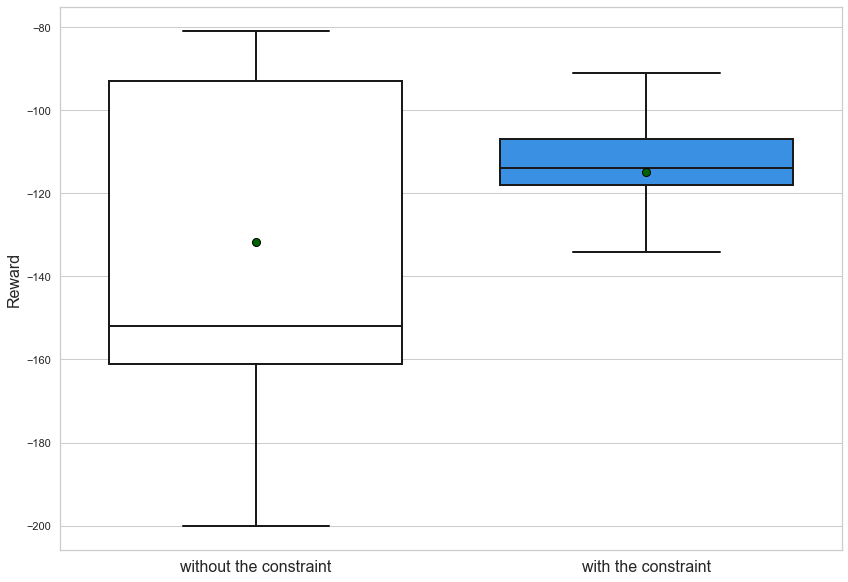

In [102]:
# Boxplot for hyperparameter
plt.figure(figsize=(14,10))

boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
#boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})

sns.set(style = 'whitegrid')
box = sns.boxplot(x = "env", y="Reward", data=df, showmeans = True, showfliers = False, 
           meanprops={"marker":"o",
                       "markerfacecolor":"darkgreen", 
                       "markeredgecolor":"black",
                      "markersize":"8"},
           **boxplot_kwargs)

#sns.pointplot(x = "env", y ="Reward", data=df, linestyles='--', scale=0.4, color='darkgreen', errwidth=0, capsize=0)

#labeling median
#medians = df.groupby(['env'])['Reward'].median().values
#medians = np.array([130, 500])
#median_labels = [str(np.round(s, 2)) for s in medians]

#pos = range(len(medians))
#for tick,label in zip(pos,box.get_xticklabels()):
#    box.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
#            horizontalalignment='center', color='k')

# control ticks, axis title
#xlabels = ['0', '0.0015', '0.015', '0.15', '0.75', '1.5']
#xlabels = ['0', '0.00035', '0.0007', '0.001', '0.0014', '0.0018', '0.014']
#xlabels = ['g 0.001', 'g 0.002', 'g 0.0025', 'g 0.003']
xlabels = ['without the constraint', 'with the constraint']
#xlabels = ['0', '3', '5']
#xlabels = ['identical','noise', 'adversary', 'DR', 'longer Pole']
box.set_xticklabels(xlabels, size=16)
box.set_xlabel('', fontsize = 16)
box.set_ylabel('Reward', fontsize = 16)

In [103]:
fig = box.get_figure()   # only for Version 2020
fig.savefig('MC_constraintVergelichforResult_ohneAusreisser.png')

Text(0, 0.5, 'Reward')

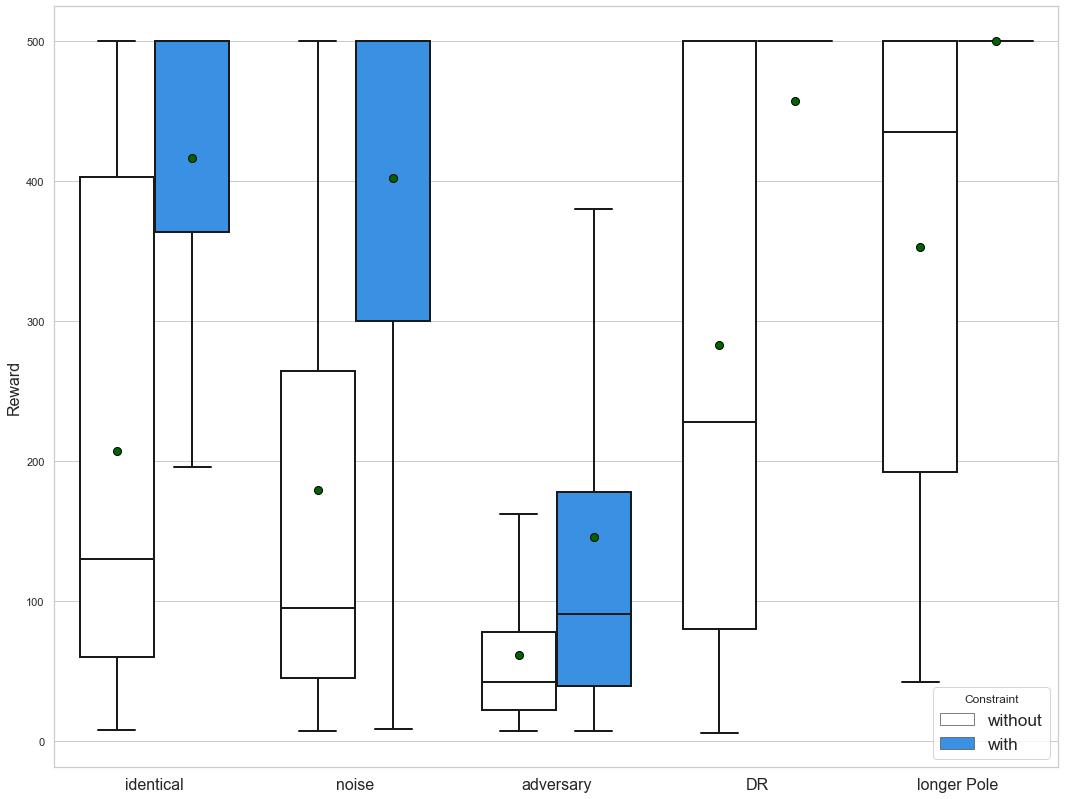

In [125]:
# Boxplot for Robustness 
plt.figure(figsize=(18,14))

#boxprops = {'edgecolor': 'k', 'linewidth': 2, 'facecolor': 'w'}
boxprops = {'edgecolor': 'k', 'linewidth': 2}
lineprops = {'color': 'k', 'linewidth': 2}
boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops,
                       'width': 0.75})

sns.set(style = 'whitegrid')
box = sns.boxplot(x = "env", y="Reward", data=df, showmeans = True, hue='lls', palette = ['white', 'dodgerblue'], showfliers = False,
           meanprops={"marker":"o",
                       "markerfacecolor":"darkgreen", 
                       "markeredgecolor":"black",
                      "markersize":"8"},
           **boxplot_kwargs)

#sns.pointplot(x = "env", y ="Reward", data=df, linestyles='--', scale=0.4, color='darkgreen', errwidth=0, capsize=0)

#labeling median
#medians = df.groupby(['env'])['Reward'].median().values
#medians = np.array([130, 500])
#median_labels = [str(np.round(s, 2)) for s in medians]

#pos = range(len(medians))
#for tick,label in zip(pos,box.get_xticklabels()):
#    box.text(pos[tick], medians[tick] + 0.5, median_labels[tick], 
#            horizontalalignment='center', color='k')

# control ticks, axis title
#xlabels = ['0', '0.00035', '0.0007', '0.001', '0.0014', '0.0018', '0.014']
#xlabels = ['g 0.001', 'g 0.002', 'g 0.0025', 'g 0.003']
#xlabels = ['without the constraint', 'with the constraint']
#xlabels = ['0', '3', '5']
xlabels = ['identical','noise', 'adversary', 'DR', 'longer Pole']
box.set_xticklabels(xlabels, size=16)
box.legend(title = 'Constraint', fontsize = 'x-large')
box.set_xlabel('', fontsize = 16)
box.set_ylabel('Reward', fontsize = 16)

In [126]:
fig = box.get_figure()   # only for Version 2020
fig.savefig('CartPole_contraint_vergleich_Robust_ohneAusreisser.png')